In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

txt_files = glob(
    "/home/goh/Documents/CLOVER/clover_utils/clover_utils/sample_data/msl/random-cumulative-split-0/*.txt"
)
txt_files = sorted(
    txt_files, key=lambda x: int(os.path.basename(x).split("pctTrain.txt")[0])
)
file_maps = [
    pd.read_csv(f, sep=" ", header=None, names=["file", "label"]) for f in txt_files
]

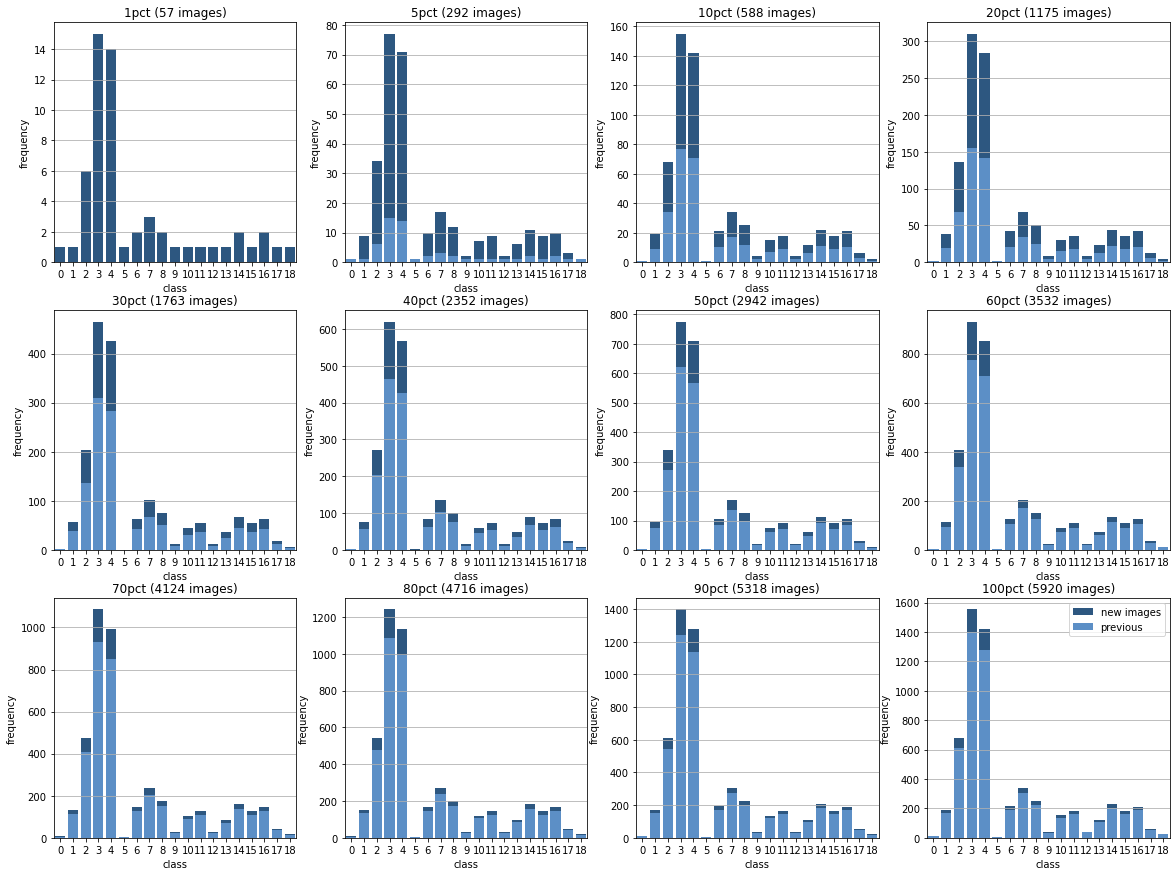

In [2]:
# plot the additional number of images from the previous file map
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
a = ax.flatten()
for i, file_map in enumerate(file_maps):
    a[i].grid()
    class_freq = file_map["label"].value_counts()
    class_freq = class_freq.reset_index().rename(
        columns={"index": "class", "label": "frequency"}
    )
    x, y = "class", "frequency"  # to use in seaborn args
    if i == 0:
        sns.barplot(x=x, y=y, data=class_freq, ax=a[i], color="#1f578e")
    else:
        sns.barplot(
            x=x,
            y=y,
            data=class_freq,
            ax=a[i],
            color="#1f578e",
            label="new images",
        )
        sns.barplot(
            x=x,
            y=y,
            data=prev_class_freq,
            ax=a[i],
            color="#4a8fd8",
            label="previous",
        )
        a[i].set_ylabel(y)
    prev_class_freq = class_freq

    a[i].set_title(
        f'{os.path.basename(txt_files[i]).split("Train.txt")[0]}'
        f" ({file_map.shape[0]} images)"
    )

plt.legend()

In [3]:
# make sure that there are no duplicates in the file maps
for i, file_map in enumerate(file_maps):
    assert len(file_map) == len(
        file_map.drop_duplicates()
    ), f"duplicate images in {txt_files[i]}"

In [5]:
# for each file map, make sure that the number of new, unique images in each class matches the number of new images in the previous file map
for i, file_map in enumerate(file_maps):
    class_freq = file_map["label"].value_counts()
    class_freq = class_freq.reset_index().rename(
        columns={"index": "class", "label": "frequency"}
    )
    if i == 0:
        prev_class_freq = class_freq
    else:
        for class_label in class_freq["class"]:
            old_images = set(
                file_maps[i - 1][file_maps[i - 1]["label"] == class_label]["file"]
            )
            new_images = set(file_map[file_map["label"] == class_label]["file"])
            num_new_images = len(new_images - old_images)

            # calculate number of new images in each class according to class_freq and prev_class_freq
            old_num_images_from_class_freq = prev_class_freq[
                prev_class_freq["class"] == class_label
            ]["frequency"].values[0]
            new_num_images_from_class_freq = class_freq[
                class_freq["class"] == class_label
            ]["frequency"].values[0]
            num_new_images_from_class_freq = (
                new_num_images_from_class_freq - old_num_images_from_class_freq
            )
            # print(
            #     f"{''.join(['=']*50)}\n"
            #     f"Number of unique images in previous file map ({i - 1}): {len(old_images)}"
            #     f"\nNumber of unique images in current file map ({i}): {len(new_images)}"
            #     f"\nNumber of new images: {len(new_images)} - {len(old_images)} = {num_new_images}"
            #     f"\n{''.join(['-']*50)}"
            #     f"\nNumber of images in previous class_freq ({i - 1}): {old_num_images_from_class_freq}"
            #     f"\nNumber of images in current class_freq ({i}): {new_num_images_from_class_freq}"
            #     f"\nNumber of new images from class_freq: {new_num_images_from_class_freq} - {old_num_images_from_class_freq} = {num_new_images_from_class_freq}"
            # )
            assert (
                num_new_images == num_new_images_from_class_freq
            ), f"Number of new images ({num_new_images}) does not match number of new images from class_freq ({num_new_images_from_class_freq})"

        prev_class_freq = class_freq